In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from collections import Counter 
from matplotlib.colors import ListedColormap
import json
import folium
%matplotlib inline
pth = r"C:\Users\wnhti\AppData\Roaming\nltk_data" #change location according to your nltk data path
nltk.data.path.append(pth)
sns.set()


## Data Exploration

In [5]:
liar_df = pd.read_csv('LIAR/train.tsv', sep='\t', header=None)

In [6]:
liar_df.head()

0            1                                                  2   \
0   2635.json        false  Says the Annies List political group supports ...   
1  10540.json    half-true  When did the decline of coal start? It started...   
2    324.json  mostly-true  Hillary Clinton agrees with John McCain "by vo...   
3   1123.json        false  Health care reform legislation is likely to ma...   
4   9028.json    half-true  The economic turnaround started at the end of ...   

                                   3               4                     5   \
0                            abortion    dwayne-bohac  State representative   
1  energy,history,job-accomplishments  scott-surovell        State delegate   
2                      foreign-policy    barack-obama             President   
3                         health-care    blog-posting                   NaN   
4                        economy,jobs   charlie-crist                   NaN   

         6           7     8     9      10     11    12                   13  
0     Texas  republican   0.0   1.0    0.0    0.0   0.0             a mailer  
1  Virginia    democrat   0.0   0.0    1.0    1.0   0.0      a floor speech.  
2  Illinois    democrat  70.0  71.0  160.0  163.0   9.0               Denver  
3       NaN        none   7.0  19.0    3.0    5.0  44.0       a news release  
4   Florida    democrat  15.0   9.0   20.0   19.0   2.0  an interview on CNN

In [7]:
liar_df.columns = ['to_drop', 'label', 'text', 'subject', 'author', 'position', 'state', 'political_party', 'pants_on_fire'\
                  , 'false', 'barely true', 'half true', 'mostly true', 'source']
liar_df = liar_df.drop(columns='to_drop')
n_rows = liar_df.shape[0]

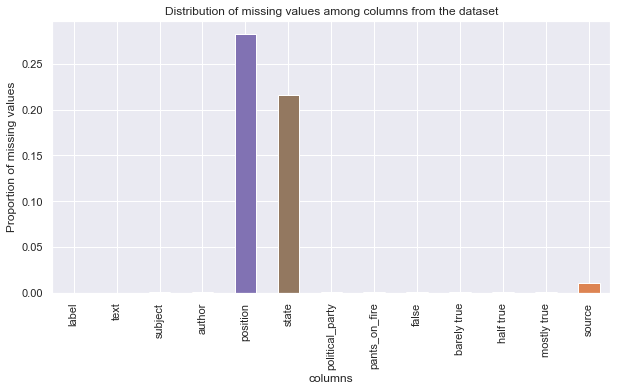

In [8]:
na_values = (liar_df.isna().sum(axis = 0)/n_rows)
na_values.plot(kind='bar', figsize=(10,5)) #proportion of na values in each column
plt.xlabel('columns')
plt.ylabel('Proportion of missing values')
plt.title('Distribution of missing values among columns from the dataset')
plt.show()

In [9]:
na_values

label              0.000000
text               0.000000
subject            0.000195
author             0.000195
position           0.282910
state              0.215625
political_party    0.000195
pants_on_fire      0.000195
false              0.000195
barely true        0.000195
half true          0.000195
mostly true        0.000195
source             0.009961
dtype: float64

In [10]:
liar_df = liar_df.dropna(subset=['subject']).reset_index(drop=True)
n_rows = liar_df.shape[0]

**We can see that most of the data is not missing, except for the position of the author of the news and the state where the news were emitted. However these two informations may be rather relevant for our classifier. We can discuss their relevance depending on our aim. The missing values represent more than 25% of the data for the position of the author and 20% for the state where the news is coming from. Hence we will need to decide after some investigation how to deal with them.**

### News Descriptive Analysis

**In order to have further insights on what is inside the data. In the next subtask we will at first focus on the text news and their label only.**

In [11]:
news = liar_df[['label', 'subject']]

In [12]:
#categorical labels
labels = ['pants-fire', 'false', 'barely-true', 'half-true', 'mostly-true', 'true']

In [13]:
label_ditribution = (news.groupby('label').count()/n_rows).T
label_ditribution = label_ditribution[labels].T

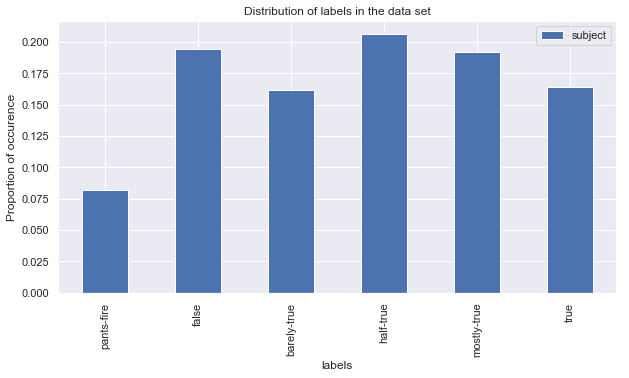

In [14]:
label_ditribution.plot(kind='bar', figsize=(10,5))
plt.xlabel('labels')
plt.ylabel('Proportion of occurence')
plt.title('Distribution of labels in the data set')
plt.show()

**We can see that the distribution of the 6 labels is quite balanced except for the pants-fire label which is less present than the other labels present roughly a little bit less than 20% of the time. When researching the source of our data, we found that the distribution of labels in our dataset is almost the same as the current one the Politifact site, where the labelling has been done. This answer us the question we had about a possible bias induced for machine learning purposes. This doesn't preserve us from the internal biases of the website indeed cowdsourcing the labelling process can lead to incorrect results.**

**From now on, we assume the dataset is a valid sample of most news' statement in the USA.**

#### a) **Get most common topics in text**

In [15]:
text = news[['label', 'subject']]

In [16]:
text.head()

label                             subject
0        false                            abortion
1    half-true  energy,history,job-accomplishments
2  mostly-true                      foreign-policy
3        false                         health-care
4    half-true                        economy,jobs

In [17]:
def tokenization(t) : 
    tokenizer = nltk.tokenize.WhitespaceTokenizer()
    return tokenizer.tokenize(t)

In [18]:
for i in range(n_rows) : 
    t = (text.iloc[i][1])
    text.iloc[i][1] = t.split(",")

In [19]:
text.head()

label                                 subject
0        false                              [abortion]
1    half-true  [energy, history, job-accomplishments]
2  mostly-true                        [foreign-policy]
3        false                           [health-care]
4    half-true                         [economy, jobs]

Separate the text according to their labels

In [20]:
false_news = text[text['label'] == 'false']
half_true_news =  text[text['label'] == 'half-true']
mostly_true_news =  text[text['label'] == 'mostly-true']
barely_true_news =  text[text['label'] == 'barely-true']
pants_fire_news =  text[text['label'] == 'pants-fire']
true_news =  text[text['label'] == 'true']

Get an important list of stopwords from the web.

In [21]:
stopwords = ''
with open('stopw.txt') as f:
        # return the split results, which is all the words in the file.
        stopwords = f.read().split()

In [22]:
#helper function used to count occurences of each topic.
def create_dataset(array) :
    dataset = ''
    for i in range(len(array)) :
        t = array[i]
        for j in range(len(t)) :
            tmp = ''.join(t[j])
            dataset += ' ' + tmp
        dataset += ' '
        split_it = dataset.split()
    counter = Counter(split_it)
    return counter


def text_to_topics(df, sw) :
    #Get the sentences from the dataset
    sentences = df['subject'].values
    #transform sentences to word tokens
    stemmer = nltk.stem.PorterStemmer()
    wordnet_lemmatizer = nltk.stem.WordNetLemmatizer()
    s = [[wordnet_lemmatizer.lemmatize(token) for token in li] for li in sentences]
    
    #transform word to lowercase and filter out stopwords
    for i in range(len(s)) :
        temp = []
        sent = s[i]
        for j in range(len(sent)) :#
            w = sent[j].lower()
            if(not w in sw) :
                temp.append(w)
        s[i] = temp
    
    #return the topics
    dataset = create_dataset(s)
    new_dataset = pd.DataFrame(list(dataset.items()), columns=['word', 'occurences'])
    new_dataset = new_dataset.sort_values(by='occurences', ascending=False)
    return new_dataset

In [23]:
def normalize_topics(subset) :
    whole_topics = text_to_topics(text, stopwords)
    for row in range(subset.shape[0]) :
        key = subset.iloc[row,0]
        topic = whole_topics[whole_topics['word'] == key]
        subset.iloc[row, 1] /= topic.iloc[0,1]
    return subset.sort_values(by='word', ascending=False)

In [24]:
NUMBER_OF_TOPICS = 20

In [25]:
def get_proportion(key, subset) : #get proportion of a topic in a corpus
    topic = subset[subset['word'] == key]
    p = 0
    try :
        p = topic.iloc[0][1]
    except :
        p = 0
    return p

def topics_to_label() :
    #get proportion of each topics for different dataframe labels
    false_topics = normalize_topics(text_to_topics(false_news, stopwords))
    half_true_topics = normalize_topics(text_to_topics(half_true_news, stopwords))
    mostly_true_topics = normalize_topics(text_to_topics(mostly_true_news, stopwords))
    barely_true_topics = normalize_topics(text_to_topics(barely_true_news, stopwords))
    pants_fire_topics = normalize_topics(text_to_topics(pants_fire_news, stopwords))
    true_topics = normalize_topics(text_to_topics(true_news, stopwords))
    
    to_df = [] #in building dataframe
    col = ['topic', 'true_statements', 'true', 'mostly-true', 'half-true', 'barely-true', 'false', 'pants-fire', 'false_statements', 'score']
    whole_topics = text_to_topics(text, stopwords)
    for row in range(whole_topics.shape[0]) :
        key = whole_topics.iloc[row,0] # get a topic
        p1 = get_proportion(key, true_topics)
        p2 = get_proportion(key, mostly_true_topics)
        p3 = get_proportion(key, half_true_topics)
        p4 = get_proportion(key,barely_true_topics)
        p5 = get_proportion(key, false_topics)
        p6 = get_proportion(key, pants_fire_topics)
        p7 = p5 + p6 # false and pants fire statements
        p8 = p1 + p2 # true and mostly statements
        p9 = p8 - p7 # score
        to_df.append([key, p8, p1, p2, p3, p4, p5, p6, p7, p9])
        
    return pd.DataFrame(to_df, columns = col)

In [26]:
topics_proportion = topics_to_label()

In [27]:
topics_proportion.head(NUMBER_OF_TOPICS)

topic  true_statements      true  mostly-true  half-true  \
0                economy         0.390706  0.177281     0.213425   0.237522   
1            health-care         0.271277  0.120567     0.150709   0.199468   
2                    tax         0.357143  0.141851     0.215292   0.208249   
3         federal-budget         0.338710  0.155914     0.182796   0.245968   
4              education         0.398352  0.159341     0.239011   0.241758   
5                    job         0.337553  0.160338     0.177215   0.261603   
6           state-budget         0.375000  0.160920     0.214080   0.193966   
7   candidates-biography         0.336907  0.148545     0.188361   0.177642   
8               election         0.397035  0.189456     0.207578   0.166392   
9            immigration         0.289474  0.105263     0.184211   0.216165   
10        foreign-policy         0.307856  0.123142     0.184713   0.197452   
11                 crime         0.385650  0.170404     0.215247   0.210762   
12               history         0.343210  0.167901     0.175309   0.165432   
13                energy         0.316754  0.146597     0.170157   0.209424   
14          legal-issues         0.398256  0.180233     0.218023   0.162791   
15           environment         0.339286  0.142857     0.196429   0.217262   
16                   gun         0.396970  0.157576     0.239394   0.221212   
17              military         0.371429  0.200000     0.171429   0.193651   
18                worker         0.426621  0.160410     0.266212   0.208191   
19   job-accomplishments         0.331058  0.136519     0.194539   0.249147   

    barely-true     false  pants-fire  false_statements     score  
0      0.152324  0.164372    0.055077          0.219449  0.171256  
1      0.192376  0.231383    0.105496          0.336879 -0.065603  
2      0.177062  0.189135    0.068410          0.257545  0.099598  
3      0.168011  0.198925    0.048387          0.247312  0.091398  
4      0.160714  0.152473    0.046703          0.199176  0.199176  
5      0.164557  0.188467    0.047820          0.236287  0.101266  
6      0.172414  0.191092    0.067529          0.258621  0.116379  
7      0.173047  0.197550    0.114855          0.312404  0.024502  
8      0.116969  0.222405    0.097199          0.319605  0.077430  
9      0.182331  0.206767    0.105263          0.312030 -0.022556  
10     0.180467  0.214437    0.099788          0.314225 -0.006369  
11     0.156951  0.159193    0.087444          0.246637  0.139013  
12     0.138272  0.232099    0.120988          0.353086 -0.009877  
13     0.164921  0.222513    0.086387          0.308901  0.007853  
14     0.154070  0.218023    0.066860          0.284884  0.113372  
15     0.151786  0.211310    0.080357          0.291667  0.047619  
16     0.127273  0.172727    0.081818          0.254545  0.142424  
17     0.158730  0.171429    0.104762          0.276190  0.095238  
18     0.197952  0.129693    0.037543          0.167235  0.259386  
19     0.133106  0.211604    0.075085          0.286689  0.044369

**We were inspired by the Net Promoter Score in marketing to design a trust score. Indeed to compute the score we substract the proportion of true and mostly true labels by the proportion of pants on fire and false labels. This method gives us a quick glance at the suspicious topics where extra caution is advised.**

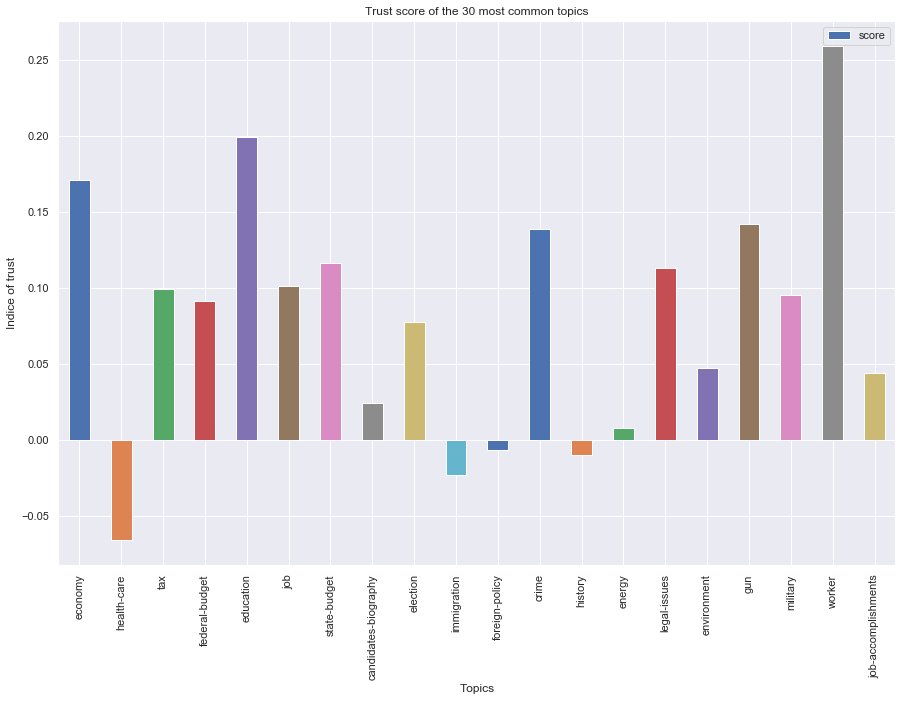

In [28]:
topics_proportion.head(NUMBER_OF_TOPICS).plot(kind='bar', x='topic', y='score', figsize=(15,10))
plt.title('Trust score of the 30 most common topics')
plt.xlabel('Topics')
plt.ylabel('Indice of trust')
plt.show()

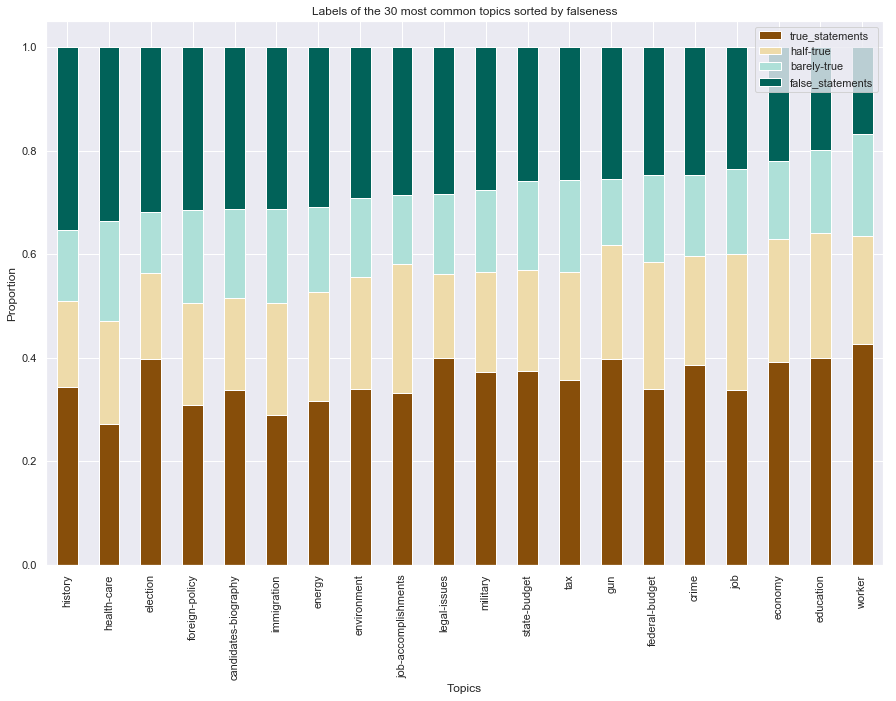

In [29]:
topics_proportion.drop(columns=['true', 'mostly-true','false', 'pants-fire', 'score']).head(NUMBER_OF_TOPICS)\
            .sort_values(by='false_statements', ascending=False).set_index('topic')\
                .plot(kind='bar', stacked=True, figsize=(15,10)\
                      ,colormap = ListedColormap(sns.color_palette('BrBG',10)))
plt.title('Labels of the 30 most common topics sorted by falseness')
plt.xlabel('Topics')
plt.ylabel('Proportion')
plt.show()

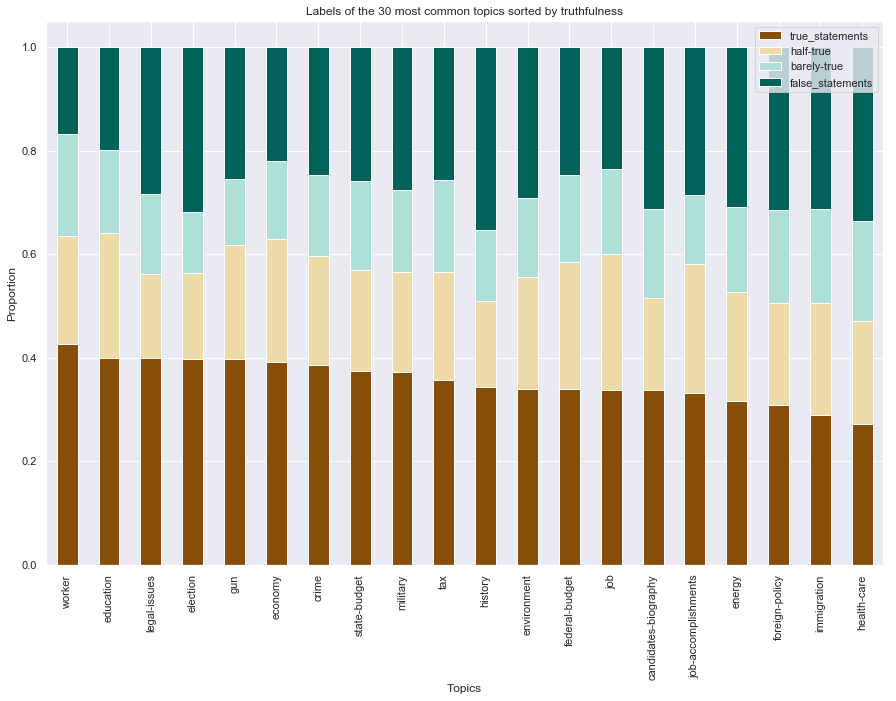

In [30]:
topics_proportion.drop(columns=['true', 'mostly-true','false', 'pants-fire', 'score']).head(NUMBER_OF_TOPICS)\
            .sort_values(by='true_statements', ascending=False).set_index('topic')\
                .plot(kind='bar', stacked=True, figsize=(15,10)\
                      ,colormap = ListedColormap(sns.color_palette('BrBG',10)))
plt.title('Labels of the 30 most common topics sorted by truthfulness')
plt.xlabel('Topics')
plt.ylabel('Proportion')
plt.show()

### Where are they coming from ?

In [31]:
states = liar_df[['label', 'state']].dropna()
states.groupby('state').count().shape[0]

84

**There are 84 states in the dataset, we should only have maximum 50 ones. When looking at the data, it seems that the spelling mistakes and the case of Washington state and DC is responsible for a large proportion of the 34 additionnal 'states'. In order to clean it, we will group them together from the actual states to find the closest string matching the ones in the dataset.**

In [32]:
def similarity(vec1, vec2) :
    l1 = len(vec1)
    l2 = len(vec2)
    k = l1
    if(l2 < l1) :
        k = l2
    p = 0
    for i in range(k) :
        if(vec1[i] in vec2) :
            p += 1
    return p/l2

def find_closest(old_text, list_text) :
    if(old_text == 'District of Columbia') :
        return "Washington, D.C."
    cosines = []
    for i in range(len(list_text)) :
        v = list_text[i]
        cos = similarity(old_text, v)
        cosines.append(cos)
    index = np.argmax(cosines)
    return list_text[index]

In [33]:
correct_states = ["Alabama","Alaska","Arizona","Arkansas","California","Colorado",
  "Connecticut","Delaware","Florida","Georgia","Hawaii","Idaho","Illinois",
  "Indiana","Iowa","Kansas","Kentucky","Louisiana","Maine","Maryland",
  "Massachusetts","Michigan","Minnesota","Mississippi","Missouri","Montana",
  "Nebraska","Nevada","New Hampshire","New Jersey","New Mexico","New York",
  "North Carolina","North Dakota","Ohio","Oklahoma","Oregon","Pennsylvania",
  "Rhode Island","South Carolina","South Dakota","Tennessee","Texas","Utah",
  "Vermont","Virginia","Washington, D.C.","Washington","West Virginia","Wisconsin","Wyoming"]

**As a measure of "truthfulness" of the origin of a news, we will assign a score to each state, depending on some "credit history" based on the proportion of the different labels.**

In [34]:
states_Copy = states.copy()
states_Copy.state = states_Copy.state.apply(lambda x : find_closest(x, correct_states))
occurences = states_Copy.groupby('state').count().reset_index()
occurences.columns = ['state', 'occurences']

scores = {'true' : 1, 'mostly-true' : 0.6, 'half-true' : 0.2, 'barely-true' : -0.2, 'pants-fire' : -0.6, 'false' : -1}
states_Copy['score'] = states_Copy.label.apply(lambda x : scores.get(x))

states_score = states_Copy.groupby('state').sum().reset_index()
states_score['occurences'] = occurences.occurences.values
states_score['score'] /= occurences['occurences'].values

In [35]:
states_score.sort_values('score', ascending=False)

state     score  occurences
32      North Dakota  0.800000           2
49           Wyoming  0.700000           4
6        Connecticut  0.345455          22
33              Ohio  0.242857         448
12          Illinois  0.225090         558
43           Vermont  0.220408          98
10            Hawaii  0.200000           1
42              Utah  0.200000          20
39      South Dakota  0.200000           3
31    North Carolina  0.200000          56
19          Maryland  0.194203          69
29        New Mexico  0.160000          30
3           Arkansas  0.157143          84
35            Oregon  0.127869         244
9            Georgia  0.127021         433
28        New Jersey  0.126971         241
7           Delaware  0.123529          68
37      Rhode Island  0.100809         371
45        Washington  0.100000          16
23          Missouri  0.100000          36
8            Florida  0.099900        1003
27     New Hampshire  0.098851          87
4         California  0.094479         163
34          Oklahoma  0.085714          14
16          Kentucky  0.075676          74
20     Massachusetts  0.075472         212
15            Kansas  0.075000          16
2            Arizona  0.073913         184
25          Nebraska  0.066667           3
44          Virginia  0.059564         413
17         Louisiana  0.040000          30
41             Texas  0.030891        1010
46  Washington, D.C.  0.019444         144
24           Montana  0.000000           2
21          Michigan -0.036364          22
40         Tennessee -0.036842          76
48         Wisconsin -0.052101         714
30          New York -0.064036         659
36      Pennsylvania -0.085714          91
1             Alaska -0.120000          65
5           Colorado -0.120000          25
38    South Carolina -0.146667          30
13           Indiana -0.157895          38
26            Nevada -0.166667          48
0            Alabama -0.171429          14
14              Iowa -0.263158          19
18             Maine -0.294915          59
47     West Virginia -0.300000           8
11             Idaho -0.333333           3
22       Mississippi -0.600000           2

**As we can see in the table above, a lot of states don't have statiscally enough labelled statements in order to be able to assess anything about them. Some of them turn out to have an important score, positive or negative, which is not necessarily significant.**

**Let's add some visualization to our results**

In [36]:
state_geo_path = r'us-states.json'
geo_json_data = json.load(open(state_geo_path))

In [37]:
us_map = folium.Map(location=[48, -102], zoom_start=3)
us_map.choropleth(geo_data=geo_json_data, data=states_score,
            columns=['state', 'score'],
             key_on='feature.properties.name',
             fill_color='YlOrRd', fill_opacity=0.7, line_opacity=0.2,
             legend_name='Credit History of USA states')

us_map

**Our visualization is not yet complete. As stated above we need to handle the non significant values.**

**A next step would be to visualize and compare political party credit history**

#### b) Analysis of most common sources

In [38]:
source_df = liar_df[['label', 'source']]
print('We have {}% of nan values in sources'.format(source_df.isna().sum()[1]/n_rows))
#since we have so few nan values that we can discard them without worrying too much
source_df = source_df.dropna()
print('When grouping them by source, we get {} differente values for sources'.format(source_df.groupby('source').agg('count').shape[0]))
print("For example, we have {} different row that contains CNN as source".format(source_df[source_df['source'].str.contains('CNN')].shape[0]))
print("Out of these 237 rows containing CNN, {} are different, this shows us the amount of little textual variations in the source"\
      .format(source_df[source_df['source'].str.contains('CNN')].groupby('source').agg('count').shape[0]))

We have 0.009767532721234616% of nan values in sources
When grouping them by source, we get 4345 differente values for sources
For example, we have 237 different row that contains CNN as source
Out of these 237 rows containing CNN, 103 are different, this shows us the amount of little textual variations in the source


We will create a bag of words, to get most common sources.

In [39]:
# use of tokenization to create a bag of words
strings = source_df['source']
bag_of_words = []
for row in strings:
    bag_of_words.extend(tokenization(row))
print('We have a {}-sized bag of words'.format(len(bag_of_words)))

# the stop words didn't filter all the useless words. '"This' was still in our top 30 words
bag_of_words = [x for x in bag_of_words if x not in stopwords]
bag_of_words =  list(filter(lambda a: a != '"This', bag_of_words))
print('We have a {}-sized cleaned bag of words'.format(len(bag_of_words)))

We have a 44284-sized bag of words
We have a 27877-sized cleaned bag of words


In [40]:
counter = Counter(bag_of_words)
sorted_counter = sorted(counter.items(), key=lambda k: k[1], reverse=True)
print('We have {} words once grouping them from the bag of words'.format(len(sorted_counter)))

We have 3139 words once grouping them from the bag of words


In [41]:
#clearly 3139 is too much to display or analyse any correlation or surprising facts
#check how many row we capture with the 30 most frequent sources
top = [x[0] for x in sorted_counter[:30]]
print('By keeping only the 30 most frequent word in source, we work with {}% of our data.'\
    .format(source_df[source_df['source'].str.contains('|'.join(top))].shape[0]/n_rows*100))

By keeping only the 30 most frequent word in source, we work with 81.60773588591522% of our data.


In [42]:
#we work now with the reduced df (the 'source' column of each row contains at least 1 word from our top list)
reduced_source = source_df[source_df['source'].str.contains('|'.join(top))]

#create an empty table that will contain the 30 most frequent words as columns, and the six categorical label as rows. 
source_table = pd.DataFrame(np.zeros((6, len(top))), columns=top)

#for each row in our df, add +1 in the new created df for each word appearing in the source column & in our top list
for index, row in reduced_source.iterrows():
    words = [s for s in top if s in row['source']]
    r = list(reversed(labels)).index(row['label'])
    for word in words:
        #row index with respect to the labels
        source_table.loc[r,word] += 1
source_table

interview  speech  campaign     ad  debate  release   news  press     TV  \
0      261.0   197.0      91.0  206.0   118.0    138.0  146.0  108.0   73.0   
1      347.0   236.0     135.0  258.0   142.0    117.0  127.0  101.0   99.0   
2      365.0   228.0     185.0  356.0   166.0    131.0  116.0   95.0  110.0   
3      259.0   135.0     176.0  343.0   141.0    126.0  124.0   84.0   86.0   
4      402.0   205.0     160.0  259.0   157.0    116.0  129.0   85.0  103.0   
5      117.0    61.0      58.0  123.0    43.0     47.0   55.0   31.0   39.0   

   radio   ...    statement  email  tweet  floor  Senate  State  video  \
0   43.0   ...         52.0   21.0   36.0   38.0    44.0   50.0   32.0   
1   43.0   ...         35.0   20.0   50.0   47.0    44.0   54.0   33.0   
2   63.0   ...         47.0   34.0   34.0   30.0    34.0   51.0   50.0   
3   71.0   ...         35.0   32.0   30.0   23.0    22.0   33.0   32.0   
4   71.0   ...         66.0   43.0   36.0   48.0    30.0   28.0   26.0   
5   37.0   ...          9.0   48.0   22.0   13.0     8.0    7.0   18.0   

   Democratic  Facebook  column  
0        28.0      16.0    34.0  
1        50.0      20.0    40.0  
2        47.0      30.0    28.0  
3        19.0      30.0    30.0  
4        16.0      28.0    30.0  
5         1.0      32.0     8.0  

[6 rows x 30 columns]

In [43]:
#function used to reduce the categorical rows together : 
# pants-fire and false, half & barely true, true & mostly true 
def reduce_categorie(df):
    result = df.copy()[:3]
    for feature_name in df.columns:
        for i in range(3):
            result[feature_name][i] = df[feature_name][2*i]+df[feature_name][2*i+1]
    return result

#function used to map our df columns in percent (0,1)
def normalize(df):
    result = df.copy()
    for feature_name in df.columns:
        total = df[feature_name].sum()
        result[feature_name] = (df[feature_name] / total)
    return result

In [44]:
reduced_df = reduce_categorie(source_table)
reduced_df

interview  speech  campaign     ad  debate  release   news  press     TV  \
0      608.0   433.0     226.0  464.0   260.0    255.0  273.0  209.0  172.0   
1      624.0   363.0     361.0  699.0   307.0    257.0  240.0  179.0  196.0   
2      519.0   266.0     218.0  382.0   200.0    163.0  184.0  116.0  142.0   

   radio   ...    statement  email  tweet  floor  Senate  State  video  \
0   86.0   ...         87.0   41.0   86.0   85.0    88.0  104.0   65.0   
1  134.0   ...         82.0   66.0   64.0   53.0    56.0   84.0   82.0   
2  108.0   ...         75.0   91.0   58.0   61.0    38.0   35.0   44.0   

   Democratic  Facebook  column  
0        78.0      36.0    74.0  
1        66.0      60.0    58.0  
2        17.0      60.0    38.0  

[3 rows x 30 columns]

In [45]:
n_reduced_df = normalize(reduced_df)
n_reduced_df

interview    speech  campaign        ad    debate   release      news  \
0   0.347230  0.407721  0.280745  0.300324  0.338983  0.377778  0.391679   
1   0.356368  0.341808  0.448447  0.452427  0.400261  0.380741  0.344333   
2   0.296402  0.250471  0.270807  0.247249  0.260756  0.241481  0.263989   

      press        TV     radio    ...     statement     email     tweet  \
0  0.414683  0.337255  0.262195    ...      0.356557  0.207071  0.413462   
1  0.355159  0.384314  0.408537    ...      0.336066  0.333333  0.307692   
2  0.230159  0.278431  0.329268    ...      0.307377  0.459596  0.278846   

      floor    Senate     State     video  Democratic  Facebook    column  
0  0.427136  0.483516  0.466368  0.340314    0.484472  0.230769  0.435294  
1  0.266332  0.307692  0.376682  0.429319    0.409938  0.384615  0.341176  
2  0.306533  0.208791  0.156951  0.230366    0.105590  0.384615  0.223529  

[3 rows x 30 columns]

In [46]:
n_df = normalize(source_table)
n_df

interview    speech  campaign        ad    debate   release      news  \
0   0.149058  0.185499  0.113043  0.133333  0.153846  0.204444  0.209469   
1   0.198172  0.222222  0.167702  0.166990  0.185137  0.173333  0.182209   
2   0.208452  0.214689  0.229814  0.230421  0.216428  0.194074  0.166428   
3   0.147915  0.127119  0.218634  0.222006  0.183833  0.186667  0.177905   
4   0.229583  0.193032  0.198758  0.167638  0.204694  0.171852  0.185079   
5   0.066819  0.057439  0.072050  0.079612  0.056063  0.069630  0.078910   

      press        TV     radio    ...     statement     email     tweet  \
0  0.214286  0.143137  0.131098    ...      0.213115  0.106061  0.173077   
1  0.200397  0.194118  0.131098    ...      0.143443  0.101010  0.240385   
2  0.188492  0.215686  0.192073    ...      0.192623  0.171717  0.163462   
3  0.166667  0.168627  0.216463    ...      0.143443  0.161616  0.144231   
4  0.168651  0.201961  0.216463    ...      0.270492  0.217172  0.173077   
5  0.061508  0.076471  0.112805    ...      0.036885  0.242424  0.105769   

      floor    Senate     State     video  Democratic  Facebook    column  
0  0.190955  0.241758  0.224215  0.167539    0.173913  0.102564  0.200000  
1  0.236181  0.241758  0.242152  0.172775    0.310559  0.128205  0.235294  
2  0.150754  0.186813  0.228700  0.261780    0.291925  0.192308  0.164706  
3  0.115578  0.120879  0.147982  0.167539    0.118012  0.192308  0.176471  
4  0.241206  0.164835  0.125561  0.136126    0.099379  0.179487  0.176471  
5  0.065327  0.043956  0.031390  0.094241    0.006211  0.205128  0.047059  

[6 rows x 30 columns]

We can not really see a general trend from the table above and the plot below, however, we can see that online publications and mail tend to have double as much fake news (pants-on-fire) than other sources, which makes them less reliable than others.

Text(0.5,0,'Sources')

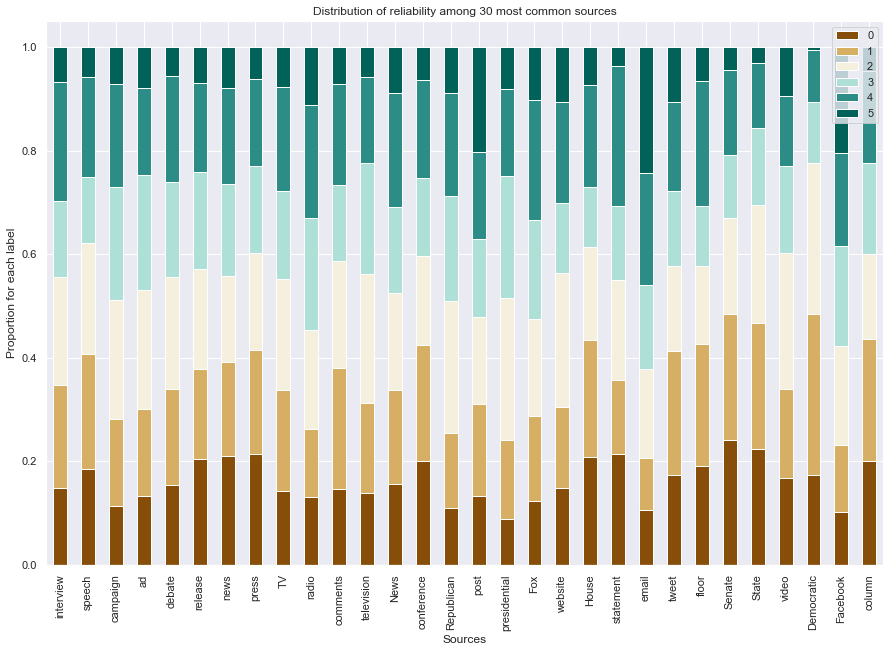

In [47]:
n_df.T.plot(kind='bar', stacked=True, figsize=(15,10), colormap = ListedColormap(sns.color_palette('BrBG',10)))
plt.title('Distribution of reliability among 30 most common sources')
plt.ylabel('Proportion for each label')
plt.xlabel('Sources')

Text(0.5,0,'Sources')

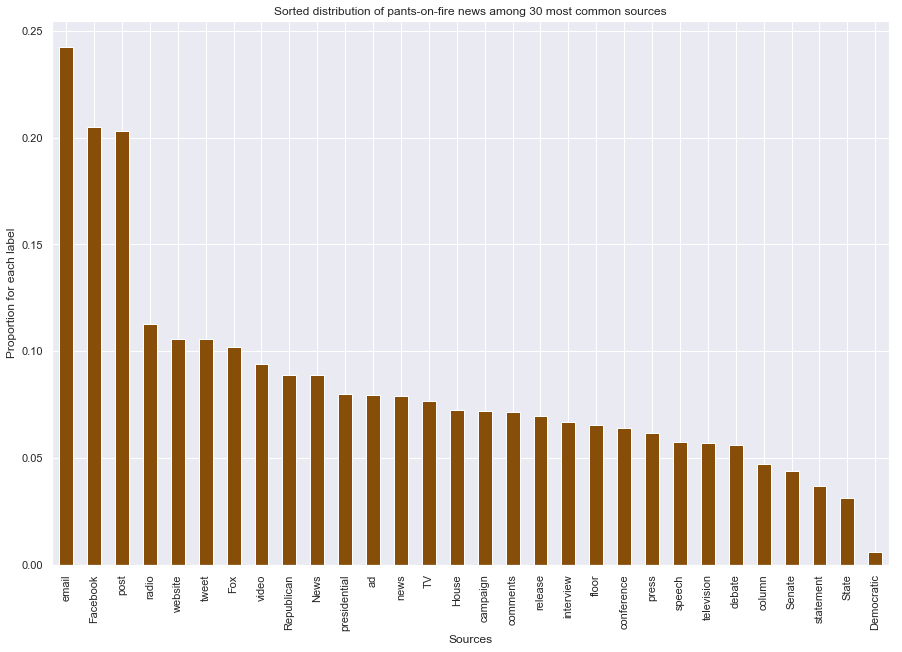

In [48]:
n_df.iloc[5]\
.sort_values(ascending=False)\
.plot(kind='bar', stacked=True, figsize=(15,10), colormap = ListedColormap(sns.color_palette('BrBG',10)))
plt.title('Sorted distribution of pants-on-fire news among 30 most common sources')
plt.ylabel('Proportion for each label')
plt.xlabel('Sources')

In [49]:
context = []
for index, row in reduced_source.iterrows():
    if 'post' in row['source']:
        context.append(row['source'])
context[:5]
#looking manually, post = social media post (facebook, instagram, web, blog, etc)

['a Facebook post',
 'a post on Instagram',
 'a web post',
 'blog posts',
 'a Facebook post']

**As stated above most fake news, in particular pants-on-fire ones, appear in higher proportion in online publications, for example on Facebook, Instagram or blogs. Hence, we should be more cautious when looking at such news on these platforms.**

## Coming next

In [55]:
import nltk
import re
#from bs4 import BeautifulSoup 
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords 

nltk.download('stopwords')
stemmer = SnowballStemmer('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\wnhti\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [56]:
def text_to_words(text):

    # Remove HTML
    #text_no_html = BeautifulSoup(text).get_text() 
    
    # Remove non-letters
    letters_only = re.sub("[^a-zA-Z]", " ", text)
    
    # Convert to lower case, split into individual words
    words = letters_only.lower().split()
    
    # In Python, searching a set is much faster than searching a list, so convert the stop words to a set
    stops = set(stopwords.words("english"))
     
    # Remove stop words
    meaningful_words = [w for w in words if not w in stops]
    
    # Stem words
    stem_words = [stemmer.stem(w) for w in meaningful_words]
    
    # Join the words back into one string separated by space and return the result
    return( " ".join( stem_words ))

In [57]:
pp_text = liar_df['text'].apply(text_to_words)

In [60]:
nltk.wordpunct_tokenize("Fuck you mom, bitch")

['Fuck', 'you', 'mom', ',', 'bitch']

In [62]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\wnhti\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping taggers\averaged_perceptron_tagger.zip.


[('Fuck', 'NNP'), ('you', 'PRP'), ('mom', 'VBP'), (',', ','), ('bitch', 'NN')]

In [63]:
nltk.pos_tag(nltk.wordpunct_tokenize(liar_df['text'][0]))

[('Says', 'VBZ'),
 ('the', 'DT'),
 ('Annies', 'NNPS'),
 ('List', 'NNP'),
 ('political', 'JJ'),
 ('group', 'NN'),
 ('supports', 'VBZ'),
 ('third', 'JJ'),
 ('-', ':'),
 ('trimester', 'NN'),
 ('abortions', 'NNS'),
 ('on', 'IN'),
 ('demand', 'NN'),
 ('.', '.')]

In [66]:
nltk.pos_tag(nltk.wordpunct_tokenize(liar_df['text'].apply(text_to_words)))

TypeError: expected string or bytes-like object

In [70]:
liar_df['text']

0        Says the Annies List political group supports ...
1        When did the decline of coal start? It started...
2        Hillary Clinton agrees with John McCain "by vo...
3        Health care reform legislation is likely to ma...
4        The economic turnaround started at the end of ...
5        The Chicago Bears have had more starting quart...
6        Jim Dunnam has not lived in the district he re...
7        I'm the only person on this stage who has work...
8        However, it took $19.5 million in Oregon Lotte...
9        Says GOP primary opponents Glenn Grothman and ...
10       For the first time in history, the share of th...
11       Since 2000, nearly 12 million Americans have s...
12       When Mitt Romney was governor of Massachusetts...
13       The economy bled $24 billion due to the govern...
14       Most of the (Affordable Care Act) has already ...
15       In this last election in November, ... 63 perc...
16       McCain opposed a requirement that the governme.

In [58]:
pp_text

0        say anni list polit group support third trimes...
1        declin coal start start natur gas took start b...
2        hillari clinton agre john mccain vote give geo...
3        health care reform legisl like mandat free sex...
4                         econom turnaround start end term
5        chicago bear start quarterback last year total...
6                     jim dunnam live district repres year
7        person stage work activ last year pass along r...
8        howev took million oregon lotteri fund port ne...
9        say gop primari oppon glenn grothman joe leibh...
10       first time histori share nation popular vote m...
11       sinc near million american slip middl class po...
12       mitt romney governor massachusett didnt slow r...
13                economi bled billion due govern shutdown
14       afford care act alreadi sens waiv otherwis sus...
15       last elect novemb percent american peopl chose...
16       mccain oppos requir govern buy american made m.

**Machine Learning**

In [ ]:
# nested cv schema
def nested_cv(X, y, est_pipe, p_grid, p_score, n_splits_inner = 3, n_splits_outer = 3, n_cores = -1, seed = 0):
    inner_cv = StratifiedKFold(n_splits = n_splits_inner, shuffle = True, random_state = seed)
    outer_cv = StratifiedKFold(n_splits = n_splits_outer, shuffle = True, random_state = seed)
    # grid search to tune hyper parameters
    est = GridSearchCV(estimator = est_pipe, param_grid = p_grid, cv = inner_cv, scoring = p_score, n_jobs = n_cores)
    # outer cv schema to assess performance of best model
    nested_scores = cross_val_score(estimator = est, X = X, y = y, cv = outer_cv, scoring = p_score, n_jobs = n_cores)
    print('\nAverage AUC: %0.4f (+/- %0.4f)' % (nested_scores.mean(), nested_scores.std() * 1.96))
    return est

In [ ]:
# Standardize features and classifier in a single pipeline
estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('lr', LogisticRegression()))
pipeline = Pipeline(estimators)
pipeline.set_params(lr__penalty='l1')

# parameter grid
p_grid = {"lr__C": [float(i) for i in np.linspace(0.01, 2.0, 15)]}
print('\n Lasso Logistic Classifier for non textual features')
#Nested cv to tune the parameter and to have an estimate for AUC
best_logistic=nested_cv(X = X_train, y = y_train_binary, est_pipe = pipeline, p_grid = p_grid, p_score = 'roc_auc', n_cores = -1)

In [ ]:
# xgboost pipeline
estimators = []
estimators.append(('xgb', XGBClassifier()))
xgb_pipe = Pipeline(estimators)
xgb_pipe.set_params(xgb__random_state = 0)
# parameter grid
p_grid = {"xgb__n_estimators": [int(i) for i in np.linspace(10.0, 300.0, 10)]}


print('\n XGBoosting for non textual features')
#Tune parameter and AUC estimate through a nested schema
best_xgb=nested_cv(X = X_train, y = y_train_binary, est_pipe = xgb_pipe, p_grid = p_grid, p_score = 'roc_auc', n_cores = -1)

In [ ]:
# SVC pipeline
estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('svm', SVC(kernel="rbf", probability=True)))
svc_pipe = Pipeline(estimators)
svc_pipe.set_params(svm__random_state = seed)
# Grid parameters
p_grid = {"svm__C": np.logspace(-4, 4, 10), "svm__gamma": np.logspace(-3, 3, 10)}
print('\nNon textual features')
best_svc = nested_cv(X = X_train, y = y_train_binary, est_pipe = svc_pipe, p_grid = p_grid, p_score = 'roc_auc', n_cores = -1)

In [ ]:
# Define a random forest pipeline
estimators = []
estimators.append(('rf', RandomForestClassifier()))
rf_pipeline = Pipeline(estimators)
rf_pipeline.set_params(rf__random_state = seed)
# parameter grid
p_grid = {"rf__n_estimators": [int(i) for i in np.linspace(100.0,300.0, 20)]}

print('\nNon textual features')
from sklearn.model_selection import StratifiedKFold, GridSearchCV
best_rf=nested_cv(X = X_train, y = y_train_binary, est_pipe = rf_pipeline, p_grid = p_grid, p_score = 'roc_auc', n_cores = -1)

The next steps and the data story we want to tell are described in the readme of the github.